In [13]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import PIL
import torch
import torchvision
import albumentations
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import OrderedDict
from torchvision import transforms, models,utils
from sklearn.metrics import accuracy_score, confusion_matrix

In [14]:
# Defining directory with data
Dir = '/kaggle/input/banane/BananaProject/'
os.listdir(Dir)

['Klasa 1 - Zuta - Zelena - popust 0',
 'Klasa 3 - Dosta fleka - popust 30',
 'Klasa 5 - Cijela crna - popust 90',
 'Klasa 2 - Zuta - Malo fleka - popust 0',
 'Klasa 4 - Pocrnila - popust 60']

In [15]:
# Creating a dataframe of paths and labels
data = {"path": [],
        "label": []
        }
z=1
for i in sorted(os.listdir(Dir)):
    print(i)
    path = os.path.join(Dir, i)
    for j in os.listdir(path):
        data['path'].append(os.path.join(path, j))
        data['label'].append(z)
    z+=1

data_df=pd.DataFrame.from_dict(data)

Klasa 1 - Zuta - Zelena - popust 0
Klasa 2 - Zuta - Malo fleka - popust 0
Klasa 3 - Dosta fleka - popust 30
Klasa 4 - Pocrnila - popust 60
Klasa 5 - Cijela crna - popust 90


In [16]:
# Checking how does the created dataframe look
data_df

,path,label
0,/kaggle/input/banane/BananaProject/Klasa 1 - Z...,1
1,/kaggle/input/banane/BananaProject/Klasa 1 - Z...,1
2,/kaggle/input/banane/BananaProject/Klasa 1 - Z...,1
3,/kaggle/input/banane/BananaProject/Klasa 1 - Z...,1
4,/kaggle/input/banane/BananaProject/Klasa 1 - Z...,1
...,...,...
495,/kaggle/input/banane/BananaProject/Klasa 5 - C...,5
496,/kaggle/input/banane/BananaProject/Klasa 5 - C...,5
497,/kaggle/input/banane/BananaProject/Klasa 5 - C...,5
498,/kaggle/input/banane/BananaProject/Klasa 5 - C...,5


In [17]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    500 non-null    object
 1   label   500 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


In [18]:
data_df["label"].value_counts()

5    100
4    100
3    100
2    100
1    100
Name: label, dtype: int64

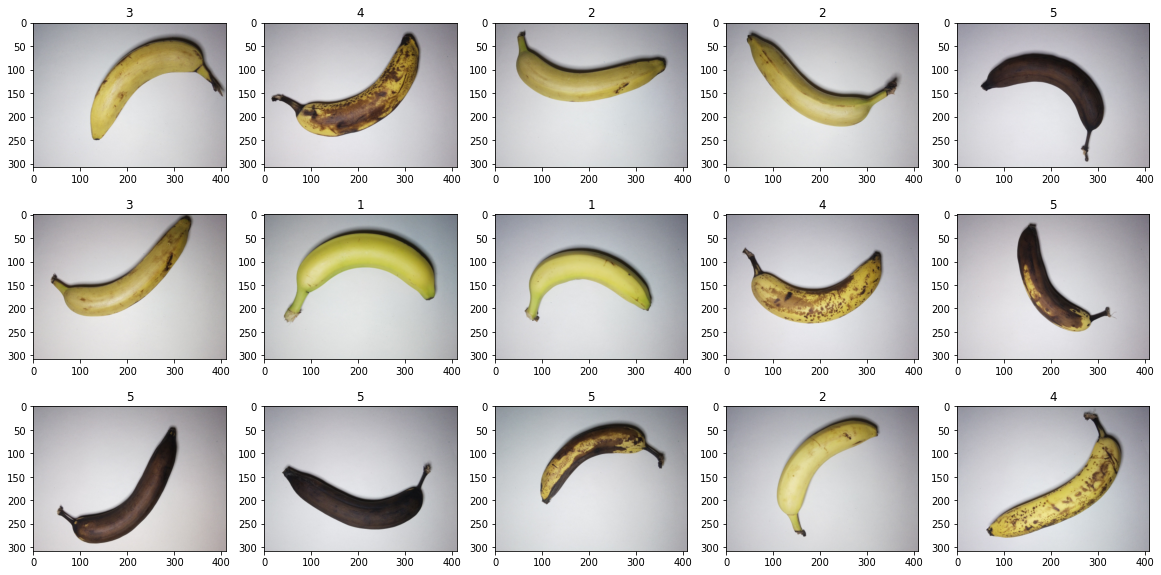

In [19]:
# Showing 15 random images
plt.figure(figsize=(20,10))

for i in range(15):
    row=data_df.sample().reset_index(drop=True)
    img = np.asarray(PIL.Image.open(row["path"][0]))
    plt.subplot(3, 5, i+1)
    plt.gca().set_title(row["label"][0])
    plt.imshow(img)
plt.show()

In [20]:
# Finding all the unique formats and dimensions of images in the dataset
dimensions=[]
formats=[]

for row in data_df.iterrows():
    img = PIL.Image.open(row[1]["path"])

    dimensions.append(np.asarray(img).shape)
    formats.append(img.format)
    
print("Dimensions of the pictures in the dataset are:", set(dimensions))
print("Formats of the pictures in the dataset are:", set(formats))

Dimensions of the pictures in the dataset are: {(308, 410, 3)}
Formats of the pictures in the dataset are: {'JPEG'}


In [21]:
# Encoding labels
le = LabelEncoder()
data_df['label'] = le.fit_transform(data_df['label'])

In [22]:
# We can pull class names with this
le.classes_

array([1, 2, 3, 4, 5])

In [23]:
# Dataframe looks like this now
data_df.head()

,path,label
0,/kaggle/input/banane/BananaProject/Klasa 1 - Z...,0
1,/kaggle/input/banane/BananaProject/Klasa 1 - Z...,0
2,/kaggle/input/banane/BananaProject/Klasa 1 - Z...,0
3,/kaggle/input/banane/BananaProject/Klasa 1 - Z...,0
4,/kaggle/input/banane/BananaProject/Klasa 1 - Z...,0


In [24]:
#Train - validation - test split :  70-20-10 %, stratified by class
#https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
train_ratio = 0.70
validation_ratio = 0.20
test_ratio = 0.10

# train is now 70% of the entire data set
train,  test = train_test_split(data_df, test_size=1 - train_ratio, random_state = 0, stratify=data_df["label"])

# test is now 20% of the initial data set
# validation is now 10% of the initial data set
validation, test = train_test_split(test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = 0, stratify=test["label"]) 


print("Train set shape:", train.shape)
print("Validation set shape:", validation.shape)
print("Test set shape:", test.shape)

Train set shape: (349, 2)
Validation set shape: (100, 2)
Test set shape: (51, 2)


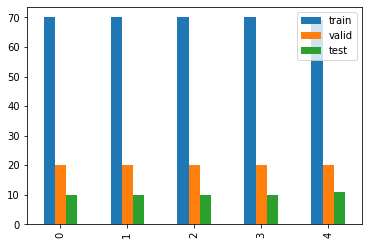

In [25]:
# Checking distribution of classes after split
_, train_counts = np.unique(train["label"], return_counts=True)
_, test_counts = np.unique(test["label"], return_counts=True)
_, valid_counts = np.unique(validation["label"], return_counts=True)
pd.DataFrame({'train': train_counts,
              'valid' : valid_counts,
                    'test': test_counts},

             
            ).plot.bar()
plt.show()

In [26]:
# Defining augmentations
"""All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. 
The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]."""

albumentations_transform = albumentations.Compose([
    albumentations.SmallestMaxSize(224), 
    albumentations.CenterCrop(224, 224),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

albumentations_transform2 = albumentations.Compose([
    albumentations.SmallestMaxSize(224), 
    albumentations.CenterCrop(224, 224),
    albumentations.Rotate(p=0.3),
    albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0),
    albumentations.OneOf([
                          albumentations.RandomRotate90(p=1),
                          albumentations.HorizontalFlip(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [27]:
# Defining dataset class
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe,transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        image=np.asarray(PIL.Image.open(row["path"]))
        
        if self.transform:
            image = self.transform(image=image)["image"]
            image = torchvision.transforms.functional.to_tensor(image)
        return (
            image,
            row["label"]
        )
    

# Initializing datasets
dataset_train = MyDataset(train,transform=albumentations_transform2)
dataset_valid = MyDataset(validation,transform=albumentations_transform)
dataset_test = MyDataset(test,transform=albumentations_transform)

In [28]:
# Initializing dataloaders
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)
validloader = torch.utils.data.DataLoader(dataset_valid, batch_size=16)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=16)

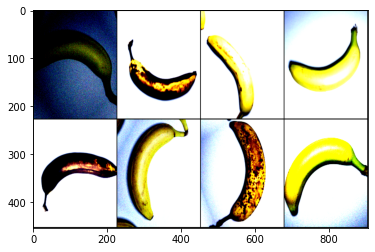

In [29]:
# To see does the data look ok in dataloader class
dataiter = iter(trainloader)
images = dataiter.next()
plt.imshow(utils.make_grid(images[0][0:8],nrow=4).permute(1,2,0),aspect='auto')
plt.show()

In [30]:
# To check if GPU is properly allocated
!nvidia-smi

Wed Sep 15 01:56:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
# Defining device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [35]:
# https://pytorch.org/vision/stable/models.html
densenet=models.densenet161(pretrained=True)
mobilenet = models.mobilenet_v2(pretrained=True)
all_models = [densenet,mobilenet]

In [36]:
# Modifying last layers, addign the same Seqential container as last element to all 3

for model in all_models:
    classifier_name, old_classifier = model._modules.popitem() 

    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    
    # Some of the models have a seqential container as last element   
    if type(old_classifier) == torch.nn.modules.container.Sequential:
        classifier_input_size = old_classifier[len(old_classifier)-1].in_features   
    else:
        classifier_input_size = old_classifier.in_features
    classifier = torch.nn.Sequential(OrderedDict([
                              ('fc1', torch.nn.Linear(classifier_input_size, 512)),
                              ('relu', torch.nn.ReLU()),
                              ('dropout', torch.nn.Dropout(p=0.5)),
                              ('fc2', torch.nn.Linear(512, 5)),
                              ('dropout2', torch.nn.Dropout(p=0.5)),
                              ('output', torch.nn.LogSoftmax(dim=1))
                              ]))
    model.add_module(classifier_name, classifier)


    model.to(device)

In [37]:
# Using the same loss criterion and optimizer for all of the models, also the same learning rate and number of epochs will be used

criterion = torch.nn.NLLLoss()
optimizer_densenet = torch.optim.Adagrad(densenet.classifier.parameters(), lr=0.01)
optimizer_mobilenet = torch.optim.Adagrad(mobilenet.classifier.parameters(), lr=0.01)

In [38]:
#Helper function for training

def training(model, optimizer, criterion, trainloader, validloader):
    epochs = 30
    steps = 0
    running_loss = 0

    train_losses, test_losses = [], []
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        

 

        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for inputs, labels in validloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)
                    
                test_loss += batch_loss.item()
                    
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(validloader))
        running_loss = 0
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Validation Loss: {:.3f}.. ".format(test_losses[-1]),
              "Validation Accuracy: {:.3f}".format(accuracy/len(validloader)))
        
    return train_losses,test_losses

In [39]:
# MobileNet_V2 Training
train_losses,valid_losses = training(mobilenet, optimizer_mobilenet, criterion, trainloader, validloader)

Epoch: 1/30..  Training Loss: 4.501..  Validation Loss: 1.076..  Validation Accuracy: 0.482
Epoch: 2/30..  Training Loss: 1.547..  Validation Loss: 0.604..  Validation Accuracy: 0.821
Epoch: 3/30..  Training Loss: 1.137..  Validation Loss: 0.548..  Validation Accuracy: 0.920
Epoch: 4/30..  Training Loss: 1.108..  Validation Loss: 0.489..  Validation Accuracy: 0.857
Epoch: 5/30..  Training Loss: 0.979..  Validation Loss: 0.484..  Validation Accuracy: 0.884
Epoch: 6/30..  Training Loss: 0.936..  Validation Loss: 0.430..  Validation Accuracy: 0.911
Epoch: 7/30..  Training Loss: 0.909..  Validation Loss: 0.328..  Validation Accuracy: 0.982
Epoch: 8/30..  Training Loss: 0.976..  Validation Loss: 0.341..  Validation Accuracy: 0.973
Epoch: 9/30..  Training Loss: 0.963..  Validation Loss: 0.367..  Validation Accuracy: 0.955
Epoch: 10/30..  Training Loss: 0.939..  Validation Loss: 0.319..  Validation Accuracy: 0.955
Epoch: 11/30..  Training Loss: 0.883..  Validation Loss: 0.311..  Validation Ac

In [40]:
# DenseNet161 Training
train_losses,valid_losses = training(densenet, optimizer_densenet, criterion, trainloader, validloader)

Epoch: 1/30..  Training Loss: 4.205..  Validation Loss: 0.835..  Validation Accuracy: 0.759
Epoch: 2/30..  Training Loss: 1.315..  Validation Loss: 0.555..  Validation Accuracy: 0.777
Epoch: 3/30..  Training Loss: 1.136..  Validation Loss: 0.544..  Validation Accuracy: 0.830
Epoch: 4/30..  Training Loss: 1.016..  Validation Loss: 0.458..  Validation Accuracy: 0.946
Epoch: 5/30..  Training Loss: 0.873..  Validation Loss: 0.406..  Validation Accuracy: 0.911
Epoch: 6/30..  Training Loss: 0.919..  Validation Loss: 0.360..  Validation Accuracy: 0.955
Epoch: 7/30..  Training Loss: 0.963..  Validation Loss: 0.389..  Validation Accuracy: 0.946
Epoch: 8/30..  Training Loss: 0.896..  Validation Loss: 0.384..  Validation Accuracy: 0.857
Epoch: 9/30..  Training Loss: 0.904..  Validation Loss: 0.309..  Validation Accuracy: 0.955
Epoch: 10/30..  Training Loss: 0.896..  Validation Loss: 0.300..  Validation Accuracy: 0.982
Epoch: 11/30..  Training Loss: 0.920..  Validation Loss: 0.306..  Validation Ac

In [44]:
# Predictions - on mobilenet
y_pred_list = []
y_true_list = []
with torch.no_grad():
    model.eval()
    for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            y_test_pred = mobilenet(inputs)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(labels.cpu().numpy())

flat_pred = []
flat_true = []
for i in range(len(y_pred_list)):
    for j in range(len(y_pred_list[i])):
        flat_pred.append(y_pred_list[i][j])
        flat_true.append(y_true_list[i][j])
        
# Evaluation of predictions on test set

print(f"number of testing samples results: {len(flat_pred)}")
print(f"Testing accuracy is: {accuracy_score(flat_true, flat_pred) * 100:.2f}%")

number of testing samples results: 51
Testing accuracy is: 94.12%


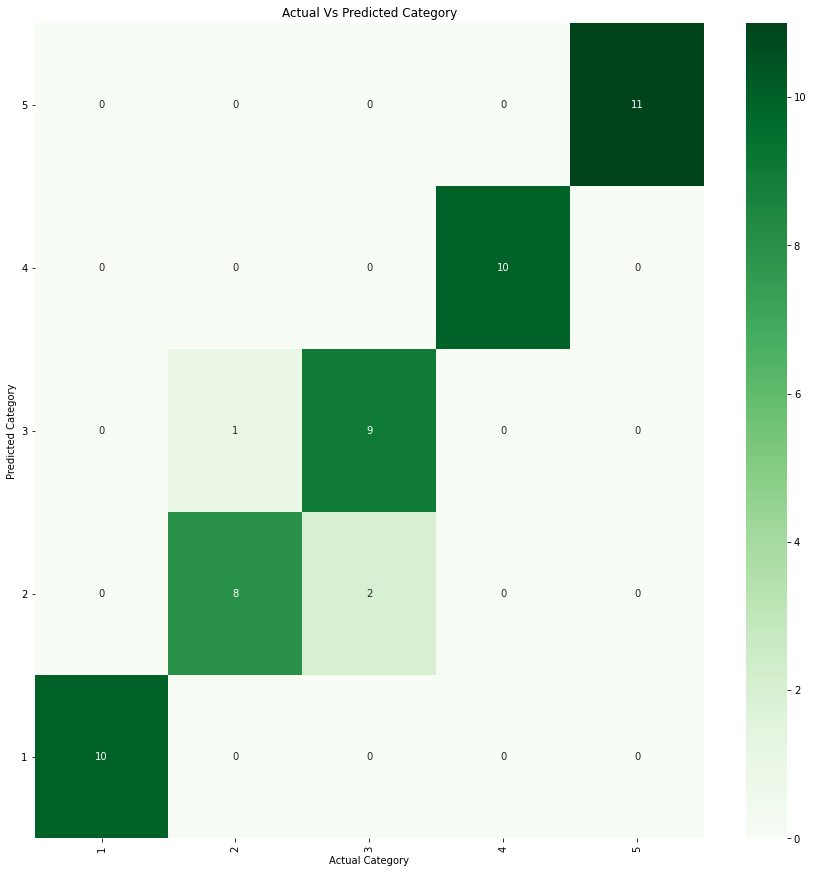

In [45]:
# Confusion Matrix
fig = plt.figure(figsize=(15,15))
conf = confusion_matrix(flat_true,flat_pred)
ax=sns.heatmap(conf,annot=True,cmap='Greens')
ax.invert_yaxis()
ax.set_xticklabels(le.classes_,rotation=90)
ax.set_yticklabels(le.classes_,rotation=0)
ax.set_xlabel('Actual Category')
ax.set_ylabel('Predicted Category')
ax.set_title('Actual Vs Predicted Category')
plt.show()

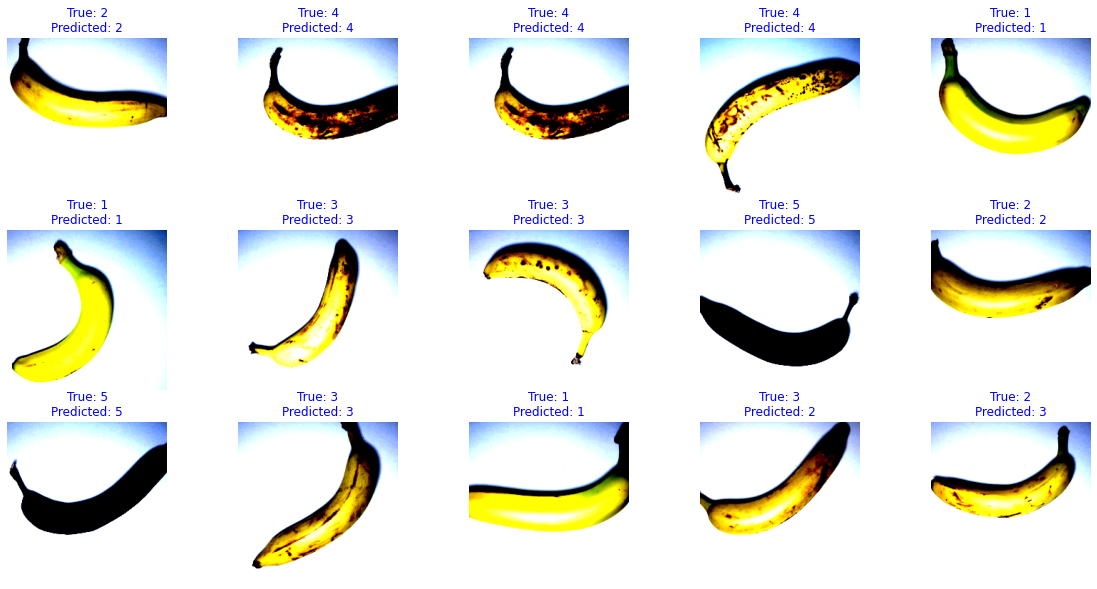

In [46]:
# Displays 15 random picture of the train dataset with their respective real and predicted labels

inds = np.random.randint(len(dataset_test), size=15)
j=1
plt.figure(figsize=(20,10))
for i in inds:
    img, label = dataset_test[i]
    plt.subplot(3, 5, j)
    plt.gca().set_title(f"True: {le.inverse_transform([label])[0]}\nPredicted: {le.inverse_transform([flat_pred[i]])[0]}",color='blue')
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    j+=1
    
plt.show()

In [50]:
# Specify a path
PATH = "final_model.pth"

# Save
torch.save(mobilenet, PATH)
